<a href="https://colab.research.google.com/github/jwkanggist/EverybodyTensorflow2.0/blob/master/lab15_alexnet_cifar100_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LAB15: alexnet for cifar100

Alexnet을 구현해보자
- Cifar100 datatset을 위한 실험


In [0]:
# preprocessor parts

from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import pandas as pd
import cv2
import numpy as np

from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt

from datetime import datetime

TensorFlow 2.x selected.


In [0]:
  # for Tensorboard use
  LOG_DIR = 'drive/data/tb_logs'
	
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip
	
  import os
  if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)
	  
  get_ipython().system_raw(
      'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
      .format(LOG_DIR))
	
  get_ipython().system_raw('./ngrok http 6006 &')
	
  !curl -s http://localhost:4040/api/tunnels | python3 -c \
      "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-01-11 15:48:33--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.225.172.191, 34.237.203.145, 34.227.168.133, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.225.172.191|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  18.3MB/s    in 0.7s    

2020-01-11 15:48:34 (18.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://ceeaf599.ngrok.io


In [0]:
# dataset loading part
# 데이터 파이프라인 부분 

cifar100 = tf.keras.datasets.cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print("x_train.shape = %s" % str(x_train.shape))
print("y_train.shape = %s" % str(x_train.shape))

x_train = x_train.reshape([x_train.shape[0],
                           x_train.shape[1],
                           x_train.shape[2],3])

x_test = x_test.reshape([x_test.shape[0],
                           x_test.shape[1],
                           x_test.shape[2],3])


x_train = np.array(tf.keras.backend.resize_images(x_train, height_factor=2,width_factor=2, data_format='channels_last',interpolation='bilinear'))
x_test = np.array(tf.keras.backend.resize_images(x_test, height_factor=2,width_factor=2, data_format='channels_last',interpolation='bilinear'))

# x_train = cv2.resize(x_train, dsize=(64,64), interpolation=cv2.INTER_CUBIC)
# x_test = cv2.resize(x_test, dsize=(64,64), interpolation=cv2.INTER_CUBIC)

print("x_train.shape = %s" % str(x_train.shape))
print("x_test.shape = %s" % str(x_test.shape))

print("y_train.shape = %s" % str(y_train.shape))
print("y_test.shape = %s" % str(y_test.shape))


169009152/169001437 [==============================] - 4s 0us/step
x_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 32, 32, 3)
x_train.shape = (50000, 64, 64, 3)
x_test.shape = (10000, 64, 64, 3)
y_train.shape = (50000, 1)
y_test.shape = (10000, 1)


In [0]:
# Network Parameters
dropout_rate =0.1
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=24,kernel_size=(11,11),strides=(1,1),activation='relu',padding='same'),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2),padding='valid'),
  tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5),strides=(1,1),activation='relu',padding='same'),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2),padding='valid'),
  tf.keras.layers.Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=1024,activation='relu'),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(units=1024,activation='relu'),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(units=100,activation='softmax')
])

opt_fn = tf.keras.optimizers.Adam(learning_rate=1e-3,
                                beta_1=0.9,
                                beta_2=0.999)

# 'sparse_categorical_crossentropy' is for integer labels
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tensorboard_callback = TensorBoard(log_dir=LOG_DIR, 
                           histogram_freq=1,
                           write_graph=True,
                           write_images=True)

NameError: ignored

In [0]:
# model training and evaluation part
training_epochs = 20
batch_size = 128

model.fit(x_train, y_train, 
          epochs=training_epochs,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          callbacks=[tensorboard_callback])
model.evaluate(x_test,  y_test, verbose=2)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 22s 441us/sample - loss: 3.5575 - accuracy: 0.1782 - val_loss: 3.5194 - val_accuracy: 0.1881
Epoch 2/50
50000/50000 [==============================] - 14s 277us/sample - loss: 2.6711 - accuracy: 0.3266 - val_loss: 2.7796 - val_accuracy: 0.3167
Epoch 3/50
50000/50000 [==============================] - 14s 277us/sample - loss: 2.1534 - accuracy: 0.4338 - val_loss: 2.5026 - val_accuracy: 0.3705
Epoch 4/50
50000/50000 [==============================] - 14s 277us/sample - loss: 1.7539 - accuracy: 0.5223 - val_loss: 2.3579 - val_accuracy: 0.4134
Epoch 5/50
50000/50000 [==============================] - 14s 277us/sample - loss: 1.3490 - accuracy: 0.6218 - val_loss: 2.3410 - val_accuracy: 0.4306
Epoch 6/50
50000/50000 [==============================] - 14s 277us/sample - loss: 0.9480 - accuracy: 0.7261 - val_loss: 2.4442 - val_accuracy: 0.4318
Epoch 7/50
50000/50000 [====================

[4.73294077758789, 0.4149]

model prediction = 33


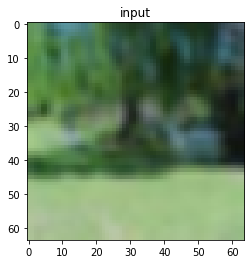

In [0]:
# prediction 

test_input = x_test[300,:,:,:]
pred_y = model.predict(test_input.reshape([1,64,64,3]))

plt.figure(1)
plt.imshow(test_input.reshape([64,64,3]))
plt.title("input")
print("model prediction = %s"% pred_y.argmax())
